In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess
from typing import Dict, List, Tuple
import pandas as pd


plt.style.use('seaborn-v0_8')
%matplotlib inline

In [ ]:
import sys
import os
sys.path.insert(0, os.getcwd())

from newton import NewtonMethod
from conjugate_gradient import ConjugateGradient
from test_functions import QuadraticFunction, RosenbrockFunction
from base import ObjectiveFunction

# 要对比的SciPy算法
SCIPY_METHODS = {
    'BFGS': {'method': 'BFGS', 'requires_hessian': False},
    'L-BFGS-B': {'method': 'L-BFGS-B', 'requires_hessian': False},
    'CG': {'method': 'CG', 'requires_hessian': False},
    'Newton-CG': {'method': 'Newton-CG', 'requires_hessian': True},
    'TNC': {'method': 'TNC', 'requires_hessian': False},
}

In [4]:
class SciPyWrapper:
    
    def __init__(self, objective_func):
        self.func = objective_func
    
    def value(self, x):
        return self.func.value(x)
    
    def gradient(self, x):
        return self.func.gradient(x)
    
    def hessian(self, x):
        return self.func.hessian(x)

class IllConditionedQuadratic(ObjectiveFunction):
    
    def __init__(self, condition_number: float = 1e6):
        super().__init__(dimension=2)
        self.condition_number = condition_number
        self.A = np.array([[1, 0], [0, condition_number]])
        self.b = np.array([0, 0])
    
    def value(self, x: np.ndarray) -> float:
        return 0.5 * x.T @ self.A @ x - self.b.T @ x
    
    def gradient(self, x: np.ndarray) -> np.ndarray:
        return self.A @ x - self.b
    
    def hessian(self, x: np.ndarray) -> np.ndarray:
        return self.A

In [5]:
def run_scipy_optimization(func_wrapper, x0, method_info, tol=1e-10, max_iter=1000):
    """运行SciPy优化算法"""
    try:
        if method_info['requires_hessian']:
            result = minimize(
                func_wrapper.value, x0, 
                method=method_info['method'],
                jac=func_wrapper.gradient,
                hess=func_wrapper.hessian,
                options={'maxiter': max_iter, 'disp': False},
                tol=tol
            )
        else:
            result = minimize(
                func_wrapper.value, x0,
                method=method_info['method'],
                jac=func_wrapper.gradient,
                options={'maxiter': max_iter, 'disp': False},
                tol=tol
            )
        return result
    except Exception as e:
        print(f"SciPy {method_info['method']} 失败: {e}")
        return None

def run_all_algorithms(func, x0, true_opt, tol=1e-10, max_iter=1000):
    results = {}
    
    algorithms = {
        'Our Newton': NewtonMethod(tol=tol, verbose=False, max_iter=max_iter),
        'Our CG': ConjugateGradient(tol=tol, verbose=False, max_iter=max_iter)
    }
    
    for name, algo in algorithms.items():
        start_time = time.time()
        result = algo.minimize(func, x0)
        elapsed = time.time() - start_time
        
        error = np.linalg.norm(result.x - true_opt) if true_opt is not None else np.nan
        
        results[name] = {
            'time': elapsed,
            'iterations': result.niter,
            'error': error,
            'success': result.success,
            'final_value': result.fun
        }
    
    # SciPy
    func_wrapper = SciPyWrapper(func)
    for name, method_info in SCIPY_METHODS.items():
        start_time = time.time()
        result = run_scipy_optimization(func_wrapper, x0, method_info, tol, max_iter)
        elapsed = time.time() - start_time
        
        if result is not None and result.success:
            error = np.linalg.norm(result.x - true_opt) if true_opt is not None else np.nan
            results[f'SciPy {name}'] = {
                'time': elapsed,
                'iterations': result.nit,
                'error': error,
                'success': result.success,
                'final_value': result.fun
            }
        else:
            results[f'SciPy {name}'] = {
                'time': np.nan,
                'iterations': np.nan,
                'error': np.nan,
                'success': False,
                'final_value': np.nan
            }
    
    return results

In [ ]:
# 实验：病态问题测试
results_2 = {}
condition_numbers = [1e2, 1e4, 1e6, 1e8]

for cn in condition_numbers:
    print(f"\n条件数: {cn:.1e}")
    
    func = IllConditionedQuadratic(condition_number=cn)
    x0 = np.array([10.0, 10.0])
    true_opt = np.array([0.0, 0.0])  # 理论最优解
    
    results_2[cn] = run_all_algorithms(func, x0, true_opt)
    
    for algo_name, algo_result in results_2[cn].items():
        if algo_result['success']:
            print(f"  {algo_name:15}: {algo_result['time']:.4f}s, "
                  f"{algo_result['iterations']:3d} iter, error: {algo_result['error']:.2e}")
        else:
            print(f"  {algo_name:15}: 失败")


条件数: 1.0e+02
  Our Newton     : 0.1741s,   1 iter, error: 0.00e+00
  Our CG         : 0.0140s, 127 iter, error: 2.59e-11
  SciPy BFGS     : 0.0030s,   4 iter, error: 9.26e-12
  SciPy L-BFGS-B : 0.0010s,   7 iter, error: 2.87e-10
  SciPy CG       : 0.0000s,   2 iter, error: 1.04e-14
  SciPy Newton-CG: 0.0000s,   3 iter, error: 1.39e-17
  SciPy TNC      : 0.0020s,   4 iter, error: 6.76e-08

条件数: 1.0e+04
  Our Newton     : 0.0000s,   1 iter, error: 0.00e+00
  Our CG         : 0.0380s, 258 iter, error: 7.40e-11
  SciPy BFGS     : 0.0000s,   4 iter, error: 4.44e-16
  SciPy L-BFGS-B : 0.0010s,   6 iter, error: 1.14e-17
  SciPy CG       : 0.0000s,   2 iter, error: 2.06e-15
  SciPy Newton-CG: 0.0000s,   3 iter, error: 2.17e-19
  SciPy TNC      : 0.0000s,   4 iter, error: 1.39e-08

条件数: 1.0e+06
  Our Newton     : 0.0000s,   1 iter, error: 0.00e+00
  Our CG         : 0.0615s, 322 iter, error: 2.56e-11
  SciPy BFGS     : 0.0010s,   5 iter, error: 1.72e-28
  SciPy L-BFGS-B : 0.0000s,   5 iter, er

C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\814704721.py:24: RuntimeWarning: overflow encountered in matmul
  return 0.5 * x.T @ self.A @ x - self.b.T @ x
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\814704721.py:24: RuntimeWarning: invalid value encountered in matmul
  return 0.5 * x.T @ self.A @ x - self.b.T @ x
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\814704721.py:27: RuntimeWarning: invalid val

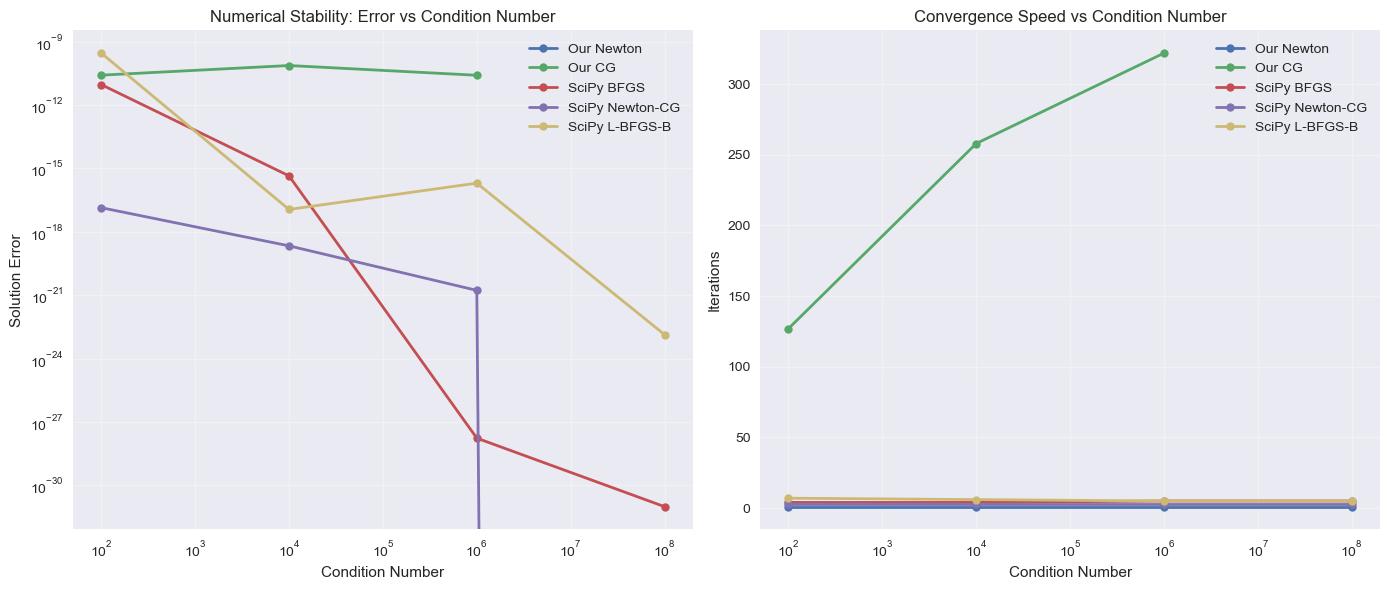

In [7]:
selected_algorithms = ['Our Newton', 'Our CG', 'SciPy BFGS', 'SciPy Newton-CG', 'SciPy L-BFGS-B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

data = {algo: {'errors': [], 'iters': []} for algo in selected_algorithms}

for cn in condition_numbers:
    for algo in selected_algorithms:
        if algo in results_2[cn] and results_2[cn][algo]['success']:
            data[algo]['errors'].append(results_2[cn][algo]['error'])
            data[algo]['iters'].append(results_2[cn][algo]['iterations'])
        else:
            data[algo]['errors'].append(np.nan)
            data[algo]['iters'].append(np.nan)

# 1. 误差 vs 条件数
for algo in selected_algorithms:
    ax1.plot(condition_numbers, data[algo]['errors'], 'o-', label=algo, linewidth=2, markersize=6)
ax1.set_xlabel('Condition Number')
ax1.set_ylabel('Solution Error')
ax1.set_title('Numerical Stability: Error vs Condition Number')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# 2. 迭代次数 vs 条件数
for algo in selected_algorithms:
    ax2.plot(condition_numbers, data[algo]['iters'], 'o-', label=algo, linewidth=2, markersize=6)
ax2.set_xlabel('Condition Number')
ax2.set_ylabel('Iterations')
ax2.set_title('Convergence Speed vs Condition Number')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# 实验：非凸问题测试
results_4 = {}

initial_points = [
    np.array([-1.5, 2.0]),    # 相对容易
    np.array([-2.0, 2.0]),    # 中等难度  
    np.array([-3.0, 3.0]),    # 困难
    np.array([-5.0, 5.0])     # 非常困难
]

difficulty_names = ['Easy', 'Medium', 'Hard', 'Very Hard']
true_opt = np.array([1.0, 1.0])  # Rosenbrock的理论最优解

for i, (x0, difficulty) in enumerate(zip(initial_points, difficulty_names)):
    print(f"\n难度 {i+1}: {difficulty}, 初始点: {x0}")
    
    func = RosenbrockFunction()

    results_4[i] = run_all_algorithms(func, x0, true_opt, tol=1e-6, max_iter=5000)

    for algo_name, algo_result in results_4[i].items():
        if algo_result['success']:
            print(f"  {algo_name:15}: {algo_result['time']:.4f}s, "
                  f"{algo_result['iterations']:4d} iter, error: {algo_result['error']:.2e}, "
                  f"f: {algo_result['final_value']:.2e}")
        else:
            print(f"  {algo_name:15}: 失败")


难度 1: Easy, 初始点: [-1.5  2. ]
  Our Newton     : 0.0051s,   22 iter, error: 8.82e-10, f: 1.56e-19
  Our CG         : 0.0180s,  208 iter, error: 3.99e-08, f: 7.77e-16
  SciPy BFGS     : 0.0030s,   37 iter, error: 2.40e-08, f: 1.97e-16
  SciPy L-BFGS-B : 0.0010s,   42 iter, error: 4.22e-06, f: 5.40e-12
  SciPy CG       : 0.0020s,   29 iter, error: 9.67e-10, f: 4.12e-16
  SciPy Newton-CG: 0.0140s,  191 iter, error: 5.83e-06, f: 6.79e-12
  SciPy TNC      : 0.0010s,   20 iter, error: 2.04e-04, f: 8.31e-09

难度 2: Medium, 初始点: [-2.  2.]
  Our Newton     : 0.0020s,   25 iter, error: 3.36e-11, f: 2.98e-22
  Our CG         : 0.0090s,  139 iter, error: 9.02e-07, f: 1.63e-13
  SciPy BFGS     : 0.0030s,   36 iter, error: 7.48e-09, f: 1.19e-17
  SciPy L-BFGS-B : 0.0010s,   37 iter, error: 1.02e-04, f: 4.63e-09
  SciPy CG       : 0.0030s,   34 iter, error: 5.56e-08, f: 6.18e-16
  SciPy Newton-CG: 0.0190s,  277 iter, error: 2.07e-09, f: 8.52e-19
  SciPy TNC      : 0.0020s,   24 iter, error: 1.74e-05, 

C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(
C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(


  Our Newton     : 0.0020s,   36 iter, error: 8.41e-10, f: 1.41e-19
  Our CG         : 0.0150s,  198 iter, error: 6.78e-07, f: 9.17e-14
  SciPy BFGS     : 0.0050s,   71 iter, error: 1.02e-09, f: 2.13e-17
  SciPy L-BFGS-B : 0.0010s,   46 iter, error: 6.07e-05, f: 1.48e-09
  SciPy CG       : 0.0020s,   26 iter, error: 8.34e-08, f: 1.39e-15
  SciPy Newton-CG: 0.1061s, 1438 iter, error: 1.39e-07, f: 3.88e-15
  SciPy TNC      : 0.0020s,   23 iter, error: 7.57e-05, f: 1.28e-09


C:\Users\Evan\AppData\Local\Temp\ipykernel_1960\1386417463.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(


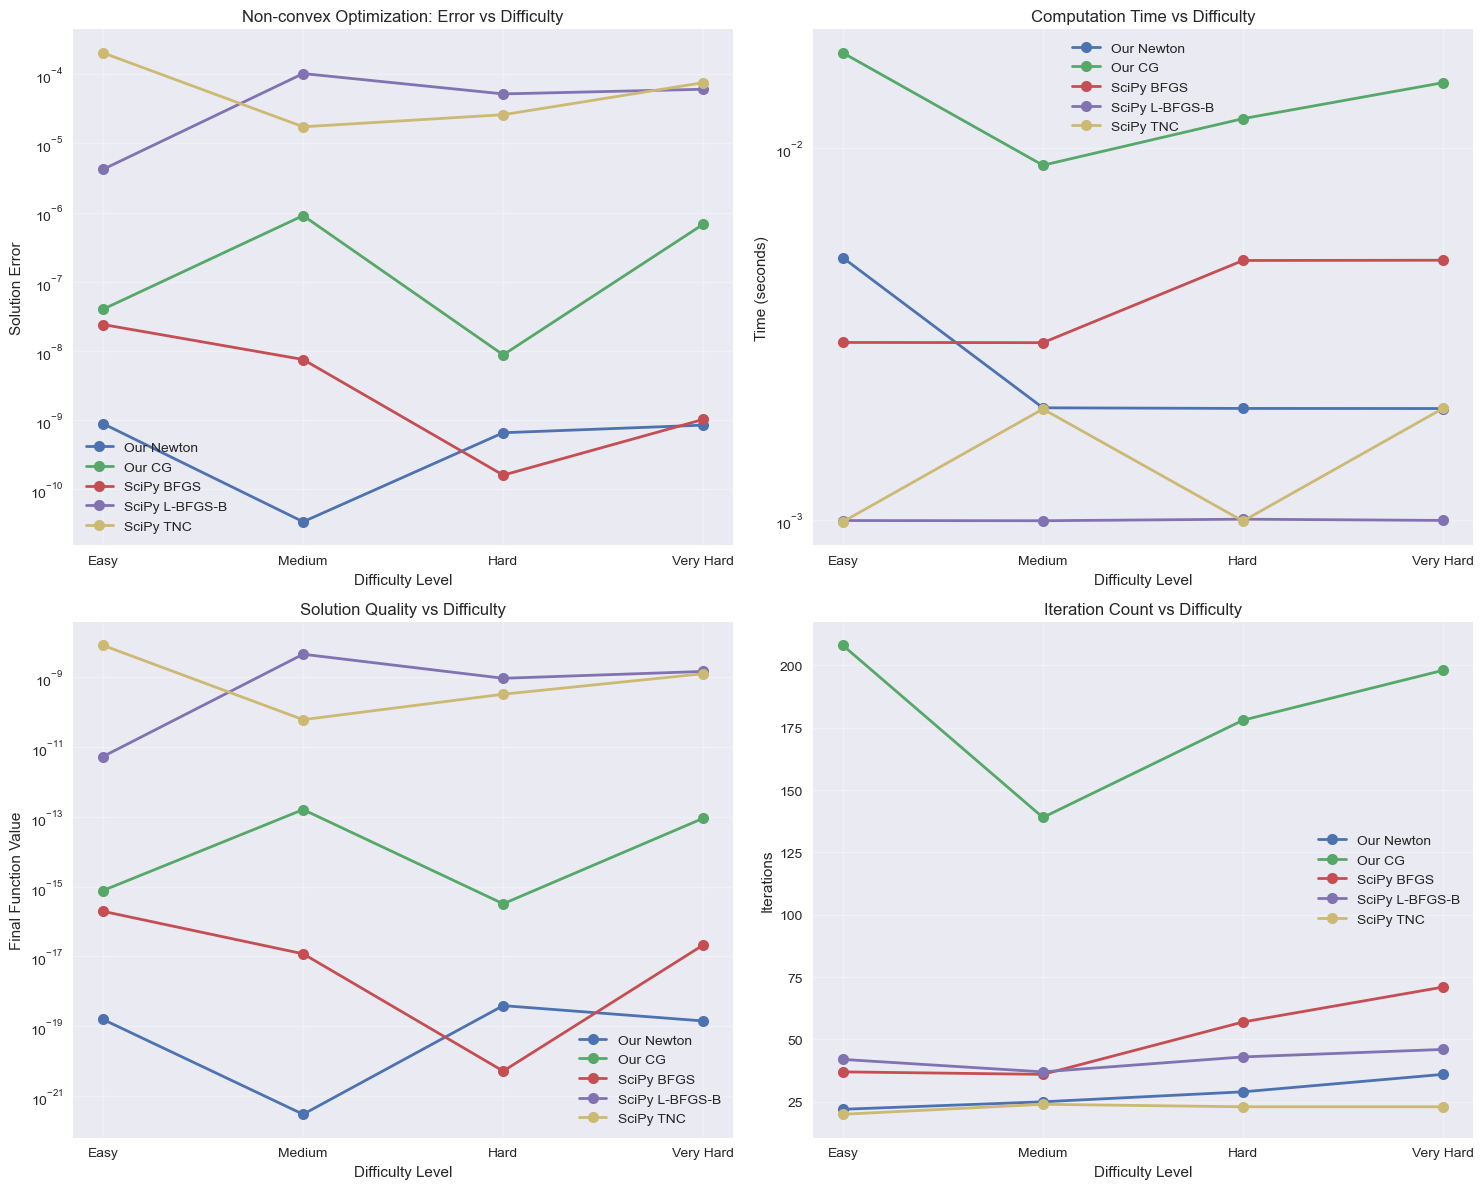

In [9]:
selected_algorithms = ['Our Newton', 'Our CG', 'SciPy BFGS', 'SciPy L-BFGS-B', 'SciPy TNC']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

data = {algo: {'errors': [], 'times': [], 'iters': [], 'values': [], 'success': []} for algo in selected_algorithms}

for i in range(len(initial_points)):
    for algo in selected_algorithms:
        if algo in results_4[i] and results_4[i][algo]['success']:
            data[algo]['errors'].append(results_4[i][algo]['error'])
            data[algo]['times'].append(results_4[i][algo]['time'])
            data[algo]['iters'].append(results_4[i][algo]['iterations'])
            data[algo]['values'].append(results_4[i][algo]['final_value'])
            data[algo]['success'].append(1)
        else:
            data[algo]['errors'].append(np.nan)
            data[algo]['times'].append(np.nan)
            data[algo]['iters'].append(np.nan)
            data[algo]['values'].append(np.nan)
            data[algo]['success'].append(0)

x_positions = range(len(initial_points))

# 1. 误差 vs 难度级别
for algo in selected_algorithms:
    ax1.plot(x_positions, data[algo]['errors'], 'o-', label=algo, linewidth=2, markersize=8)
ax1.set_xlabel('Difficulty Level')
ax1.set_ylabel('Solution Error')
ax1.set_title('Non-convex Optimization: Error vs Difficulty')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(difficulty_names)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. 计算时间 vs 难度级别
for algo in selected_algorithms:
    ax2.plot(x_positions, data[algo]['times'], 'o-', label=algo, linewidth=2, markersize=8)
ax2.set_xlabel('Difficulty Level')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Computation Time vs Difficulty')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(difficulty_names)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. 最终函数值 vs 难度级别
for algo in selected_algorithms:
    ax3.plot(x_positions, data[algo]['values'], 'o-', label=algo, linewidth=2, markersize=8)
ax3.set_xlabel('Difficulty Level')
ax3.set_ylabel('Final Function Value')
ax3.set_title('Solution Quality vs Difficulty')
ax3.set_xticks(x_positions)
ax3.set_xticklabels(difficulty_names)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. 迭代次数 vs 难度级别
for algo in selected_algorithms:
    ax4.plot(x_positions, data[algo]['iters'], 'o-', label=algo, linewidth=2, markersize=8)
ax4.set_xlabel('Difficulty Level')
ax4.set_ylabel('Iterations')
ax4.set_title('Iteration Count vs Difficulty')
ax4.set_xticks(x_positions)
ax4.set_xticklabels(difficulty_names)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()